# 제2회 신약 개발 AI 경진대회

---

# Import & Settings

In [3]:
%pip install -q rdkit seaborn matplotlib scikit-learn

In [26]:
import pandas as pd
import numpy as np
import os
import random
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# 분자 모델링 라이브러리
from rdkit import Chem         # smiles, sdf파일로부터 분자 객체 생성
from rdkit.Chem import AllChem # 고급 화학 계산(3D좌표 생성, 분자 역학, 분자 최적화, 유사도 계산 등)
from rdkit.Chem.Descriptors import ( # 분자 서술자
    ExactMolWt, 
    MolLogP, 
    TPSA, 
    NumRotatableBonds, 
    NumHDonors, 
    NumHAcceptors,
)
from rdkit.Chem import rdMolDescriptors

In [2]:
CFG = {
    'NBITS':2048, # 분자 지문(Fingerprint) 생성시 사용할 이진 벡터 길이
    'SEED':42,
}

In [3]:
def seed_everything(seed):
    """ SEED로부터 난수 생성 """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED'])

In [7]:
# 구글 드라이브 연결
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
# 시각화 모듈 관련 설정
warnings.filterwarnings('ignore')           # 출력 창 경고 메시지 무시
plt.rcParams['axes.unicode_minus'] = False  # 음수부호 깨짐 관련
plt.rcParams['font.family'] = 'AppleGothic' # mac os 전용 한글 폰트 설정
# plt.rcParams['font.family'] = 'Malgun Gothic' # window 전용 한글 폰트 설정

In [4]:
ROOT_DIR_GOOGLEDRIVE = '/content/drive/MyDrive/Contest/New-Medinine-Dev/'
ROOT_DIR_LOCAL = '..'

# Load Data

In [9]:
# 학습 ChEMBL 데이터 로드
chembl_df = pd.read_csv(f'{ROOT_DIR_LOCAL}/data/train.csv')
display(chembl_df)

,Molecule ChEMBL ID,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Assay ChEMBL ID,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,IC50_nM,pIC50,Smiles
0,CHEMBL4443947,IC50,'=',0.022,nM,10.66,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,0.022,10.66,CN[C@@H](C)C(=O)N[C@H](C(=O)N1C[C@@H](NC(=O)CC...
1,CHEMBL4556091,IC50,'=',0.026,nM,10.59,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.026,10.59,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
2,CHEMBL4566431,IC50,'=',0.078,nM,10.11,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.078,10.11,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
3,CHEMBL4545898,IC50,'=',0.081,nM,10.09,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.081,10.09,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
4,CHEMBL4448950,IC50,'=',0.099,nM,10.00,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,0.099,10.00,COc1cc2c(OC[C@@H]3CCC(=O)N3)ncc(C#CCCCCCCCCCCC...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,CHEMBL380009,IC50,'=',30000.000,nM,4.52,CHEMBL870864,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL1147720,30000.000,4.52,O=C(Nc1nc2cc[nH]cc-2n1)c1cccc([N+](=O)[O-])c1
1948,CHEMBL377654,IC50,'=',30000.000,nM,4.52,CHEMBL870864,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL1147720,30000.000,4.52,CCCCn1c(NC(=O)c2cccc(Cl)c2)nc2ccccc21
1949,CHEMBL208667,IC50,'=',30000.000,nM,4.52,CHEMBL870864,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL1147720,30000.000,4.52,O=C(Nc1nc2cc(F)c(F)cc2[nH]1)c1cccc([N+](=O)[O-...
1950,CHEMBL3403453,IC50,'=',42000.000,nM,4.38,CHEMBL3407004,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL3400143,42000.000,4.38,OC[C@H]1C[C@@H](Nc2nc(Nc3ccccc3)ncc2-c2nc3cccc...


In [10]:
chembl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1952 entries, 0 to 1951
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Molecule ChEMBL ID  1952 non-null   object 
 1   Standard Type       1952 non-null   object 
 2   Standard Relation   1952 non-null   object 
 3   Standard Value      1952 non-null   float64
 4   Standard Units      1952 non-null   object 
 5   pChEMBL Value       1952 non-null   float64
 6   Assay ChEMBL ID     1952 non-null   object 
 7   Target ChEMBL ID    1952 non-null   object 
 8   Target Name         1952 non-null   object 
 9   Target Organism     1952 non-null   object 
 10  Target Type         1952 non-null   object 
 11  Document ChEMBL ID  1952 non-null   object 
 12  IC50_nM             1952 non-null   float64
 13  pIC50               1952 non-null   float64
 14  Smiles              1952 non-null   object 
dtypes: float64(4), object(11)
memory usage: 228.9+ KB


In [11]:
chembl_df.describe()

,Standard Value,pChEMBL Value,IC50_nM,pIC50
count,1952.000000,1952.000000,1952.000000,1952.000000
mean,649.001365,7.518586,649.001365,7.518586
std,2639.946734,1.107959,2639.946734,1.107959
min,0.022000,4.260000,0.022000,4.260000
25%,4.100000,6.680000,4.100000,6.680000
50%,15.250000,7.820000,15.250000,7.820000
75%,209.197500,8.390000,209.197500,8.390000
max,55000.000000,10.660000,55000.000000,10.660000


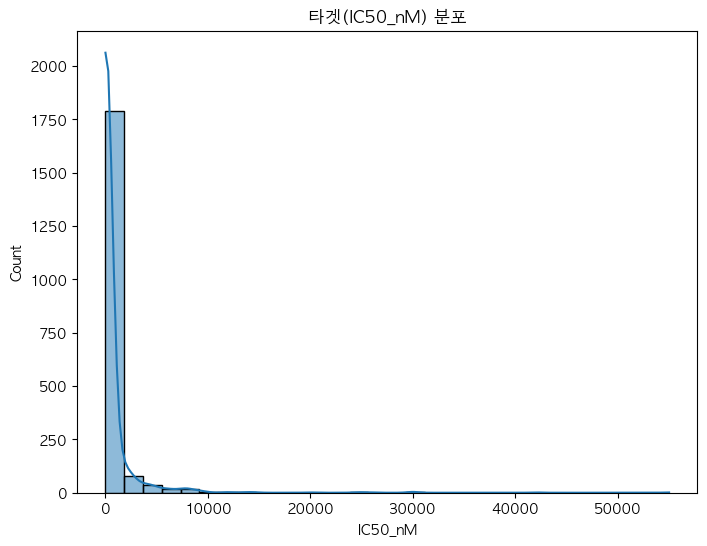

In [21]:
# 타겟 값 분포 시각화
plt.figure(figsize=(8, 6))
sns.histplot(chembl_df['IC50_nM'], kde=True, bins=30)
plt.title('타겟(IC50_nM) 분포')
plt.show()

# Data Pre-processing

## 피처 추출

In [23]:
def smiles_to_fingerprint(smiles):
    """ 
    SMILES => fingerprint(분자 지문)
    - 분자 지문이란, 분자의 구조를 이진 벡터 형태로 표현하며 각 벡터의 위치는 특정 화학적 결합 또는 원자 그룹의 존재 여부를 나타냄.
    - 분자 지문(Fingerprint)의 특성:
	    - 1: 특정 화학적 결합이나 원자 그룹이 분자 내에 존재함을 나타냅니다.
	    - 0: 해당 결합이나 패턴이 존재하지 않음을 의미합니다.
    """
    mol = Chem.MolFromSmiles(smiles) # smiles 문자열을 분자 객체로 변환
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=CFG['NBITS']) # Morgan Fingerprint 이용하여 분자 지문 생성
        return np.array(fp)
    else:
        return np.zeros((CFG['NBITS'],))

In [24]:
def smiles_to_descriptors(smiles) -> dict:
    """ 
    SMILES => descriptors(분자 서술자)
    """
    mol = Chem.MolFromSmiles(smiles) # smiles 문자열을 분자 객체로 변환
    if mol:
        return {
            'NRB': NumRotatableBonds(mol), # 회전 가능한 결합 수
        }
    else:
        # 유효하지 않은 SMILES인 경우 모든 서술자를 0으로 반환
        return {
            'NRB': 0,
        }

In [25]:
def smiles_to_ro5_descriptors(smiles) -> dict:
    """
    SMILES => Ro5 Violations, Ro5계산에 사용된 분자서술자 4개 피처(descriptors)
    - 출처 : https://chembl.gitbook.io/chembl-interface-documentation/frequently-asked-questions/drug-and-compound-questions 
    """
    mol = Chem.MolFromSmiles(smiles)
    
    if mol:
        # 분자 서술자 계산
        mol_wt = ExactMolWt(mol) # 화합물의 분자량(Molecular Weight) = 분자의 총 질량 (단위 [Da],Dalton) # MolWt(평균분자량), HeavyAtomMolWt(수소제외평균분자량)
        alogp = MolLogP(mol) # 로그 P 값 = 화합물의 물과 지질(지방)에서의 분포 나타냄 (지질-수용액 분배 계수)
        hbd = NumHDonors(mol) # 수소 기증자 수
        hba = NumHAcceptors(mol) # 수소 수용자 수
        
        # RO5 위반 횟수 계산
        violations = 0
        if mol_wt > 500:
            violations += 1
        if alogp > 5:
            violations += 1
        if hbd > 5:
            violations += 1
        if hba >= 10:
            violations += 1
        
        return {
            'MolWt': mol_wt,
            'ALogP': alogp,
            'HBD': hbd,
            'HBA': hba,
            'RO5': violations
        }
    else:
        return {
            'MolWt': 0, 'ALogP': 0, 'HBD': 0, 'HBA': 0, 'RO5': 0,
        }
    

In [38]:
def calculate_ligand_efficiency(smiles, IC50_nM, pIC50) -> dict:
    """
    SMILES => LE, PEI, BEI, SEI 지표 + TPSA
    """
    mol = Chem.MolFromSmiles(smiles)
    
    if mol:
        mol_wt = ExactMolWt(mol)  # 분자량 (단위 : [Da]달톤)
        N = rdMolDescriptors.CalcNumHeavyAtoms(mol)  # 비수소 원자 수
        tpsa = TPSA(mol)  # 극성 표면적 (Topological Polar Surface Area)
        # log_p = MolLogP(mol)  # LogP (분배 계수)
        
        # LE 계산: 1.4 * (-log IC50) / 비수소 원자 수
        IC50_M = IC50_nM * 1e-9 # IC50 값이 나노몰(nM) 단위로 주어졌으므로 이를 몰(M)로 변환: IC50_nM * 1e-9
        le = 1.4 * ((-np.log10(IC50_M)) / N if N > 0 else None)

        # BEI 계산: pIC50 / 분자량[kDa, 킬로달톤]
        bei = pIC50 / (mol_wt / 1000) if mol_wt > 0 else None

        # SEI 계산: pIC50 / (TPSA / 100 Å)
        sei = pIC50 / (tpsa / 100) if tpsa > 0 else None
        
        # PEI 계산: 억제율 (%)을 분율로 나눈 값 / 분자량[kDa, 킬로달톤]
        # pei = inhibition_fraction / (mol_wt / 1000) if mol_wt > 0 else None

        return {
            'LE': le,
            'BEI': bei,
            'SEI': sei,
            'TPSA': tpsa,
        }
    else:
        # 유효하지 않은 SMILES 문자열일 경우 None 반환
        return {'LE': None, 'PEI': None, 'BEI': None, 'SEI': None, 'TPSA': None}

In [28]:
# 분자지문 피처 추출
chembl_df['Fingerprint'] = chembl_df['Smiles'].apply(smiles_to_fingerprint) # Smiles -> Fingerprint 추출
chembl_df['Fingerprint'] = np.stack(chembl_df['Fingerprint'].values) # Fingerprint 컬럼에서 각 분자의 지문을 배열로 변환

[22:26:04] DEPRECATION WARNING: please use MorganGenerator
[22:26:04] DEPRECATION WARNING: please use MorganGenerator
[22:26:04] DEPRECATION WARNING: please use MorganGenerator
[22:26:04] DEPRECATION WARNING: please use MorganGenerator
[22:26:04] DEPRECATION WARNING: please use MorganGenerator
[22:26:04] DEPRECATION WARNING: please use MorganGenerator
[22:26:04] DEPRECATION WARNING: please use MorganGenerator
[22:26:04] DEPRECATION WARNING: please use MorganGenerator
[22:26:04] DEPRECATION WARNING: please use MorganGenerator
[22:26:04] DEPRECATION WARNING: please use MorganGenerator
[22:26:04] DEPRECATION WARNING: please use MorganGenerator
[22:26:04] DEPRECATION WARNING: please use MorganGenerator
[22:26:04] DEPRECATION WARNING: please use MorganGenerator
[22:26:04] DEPRECATION WARNING: please use MorganGenerator
[22:26:04] DEPRECATION WARNING: please use MorganGenerator
[22:26:04] DEPRECATION WARNING: please use MorganGenerator
[22:26:04] DEPRECATION WARNING: please use MorganGenerat

In [30]:
# RO5 위반수, 화합물 분자량, ALogP, 수소기증자 수, 수소 수용자수 피처 추출
ro5_df = chembl_df['Smiles'].apply(smiles_to_ro5_descriptors)
ro5_df = pd.DataFrame(ro5_df.tolist())
chembl_desc_df = pd.concat([chembl_df, ro5_df], axis=1) # chembl_df, ro5_df 병합

In [32]:
# 분자 서술자(회전가능결합수) 피처 추출
desc_df = chembl_desc_df['Smiles'].apply(smiles_to_descriptors) # SMILES -> 분자 서술자
desc_df = pd.DataFrame(desc_df.tolist())
chembl_desc2_df = pd.concat([chembl_desc_df, desc_df], axis=1) # chembl_df, desc_df 병합

In [39]:
# 분자 서술자(LE, BEI, SEI, TPSA) 피처 추출
efficiency_df = chembl_desc2_df.apply(
    lambda row: calculate_ligand_efficiency(row['Smiles'], row['IC50_nM'], row['pIC50']),
    axis=1
)
efficiency_df = pd.DataFrame(efficiency_df.tolist()) # 데이터프레임으로 변환
chembl_desc3_df = pd.concat([chembl_desc2_df, efficiency_df], axis=1) # 새로운 피처 추가 (병합)

In [40]:
display(chembl_desc3_df)

,Molecule ChEMBL ID,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Assay ChEMBL ID,Target ChEMBL ID,Target Name,Target Organism,...,MolWt,ALogP,HBD,HBA,RO5,NRB,LE,BEI,SEI,TPSA
0,CHEMBL4443947,IC50,'=',0.022,nM,10.66,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,994.516405,2.74360,1,1,0,23,0.207231,10.718777,4.249213,250.87
1,CHEMBL4556091,IC50,'=',0.026,nM,10.59,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,535.270716,2.72090,1,0,0,7,0.379975,19.784381,9.961434,106.31
2,CHEMBL4566431,IC50,'=',0.078,nM,10.11,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,537.249981,1.56720,1,0,0,7,0.362848,18.818056,8.750216,115.54
3,CHEMBL4545898,IC50,'=',0.081,nM,10.09,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,545.236222,2.43350,1,0,0,8,0.362260,18.505740,9.491111,106.31
4,CHEMBL4448950,IC50,'=',0.099,nM,10.00,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,935.461533,6.49322,1,0,0,21,0.209046,10.689910,4.647488,215.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,CHEMBL380009,IC50,'=',30000.000,nM,4.52,CHEMBL870864,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,283.070539,2.07000,0,0,0,3,0.301525,15.967751,3.971531,113.81
1948,CHEMBL377654,IC50,'=',30000.000,nM,4.52,CHEMBL870864,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,327.113840,4.74210,0,0,0,5,0.275306,13.817820,9.633419,46.92
1949,CHEMBL208667,IC50,'=',30000.000,nM,4.52,CHEMBL870864,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,318.056447,3.00160,0,0,0,3,0.275306,14.211314,4.478795,100.92
1950,CHEMBL3403453,IC50,'=',42000.000,nM,4.38,CHEMBL3407004,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,449.152161,3.01140,0,0,0,6,0.191483,9.751706,3.548858,123.42


## 데이터 분석

In [41]:
chembl_dataset = chembl_desc3_df.copy()
chembl_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1952 entries, 0 to 1951
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Molecule ChEMBL ID  1952 non-null   object 
 1   Standard Type       1952 non-null   object 
 2   Standard Relation   1952 non-null   object 
 3   Standard Value      1952 non-null   float64
 4   Standard Units      1952 non-null   object 
 5   pChEMBL Value       1952 non-null   float64
 6   Assay ChEMBL ID     1952 non-null   object 
 7   Target ChEMBL ID    1952 non-null   object 
 8   Target Name         1952 non-null   object 
 9   Target Organism     1952 non-null   object 
 10  Target Type         1952 non-null   object 
 11  Document ChEMBL ID  1952 non-null   object 
 12  IC50_nM             1952 non-null   float64
 13  pIC50               1952 non-null   float64
 14  Smiles              1952 non-null   object 
 15  Fingerprint         1952 non-null   int64  
 16  MolWt 

object 타입의 컬럼들을 먼저 처리해 줘야할 것 같다.

- Molecule ChEMBLE ID, Assay ChEMBL ID, Document ChEMBL ID는 각각 데이터베이스, 에세이, 문서의 고유 식별자이므로 제거 대상
- Standard Type, Standard Relation, Standard Units, Target ChEMBL ID, Target Name, Target Organism, Target Type 은 모두 같은 값을 가지는지 확인 후 같다면 제거
- Smiles는 필요하므로 냅두기

In [42]:
# 1. 데이터베이스, 에세이, 문서 식별자 피처 삭제

chembl_dataset = chembl_dataset.drop(['Molecule ChEMBL ID', 'Assay ChEMBL ID', 'Document ChEMBL ID'], axis=1)

In [44]:
# 2. 모두 같은 값을 가지는 컬럼 제거

# 각 컬럼이 모두 동일한 값을 가지는지 확인
columns_to_check = [
    'Standard Type', 'Standard Relation', 'Standard Units', 
    'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type'
]
# 모든 값이 동일한지 확인 -> 모든 값이 동일하다면 True
same_values = chembl_dataset[columns_to_check].nunique() == 1
# 결과 출력
print(f'모든 값이 동일한지 확인(동일하다면 True) : \n{same_values}')

# 동일한 값을 가진 컬럼만 필터링하여 삭제
columns_to_drop = same_values[same_values].index.tolist()
chembl_dataset = chembl_dataset.drop(columns_to_drop, axis=1)

Standard Type        True
Standard Relation    True
Standard Units       True
Target ChEMBL ID     True
Target Name          True
Target Organism      True
Target Type          True
dtype: bool


In [46]:
# 'Smiles' 컬럼을 앞으로 이동시키고 결과 확인
columns = ['Smiles'] + [col for col in chembl_dataset.columns if col != 'Smiles']
chembl_dataset = chembl_dataset[columns]
display(chembl_dataset)

,Smiles,Standard Value,pChEMBL Value,IC50_nM,pIC50,Fingerprint,MolWt,ALogP,HBD,HBA,RO5,NRB,LE,BEI,SEI,TPSA
0,CN[C@@H](C)C(=O)N[C@H](C(=O)N1C[C@@H](NC(=O)CC...,0.022,10.66,0.022,10.66,1,994.516405,2.74360,1,1,0,23,0.207231,10.718777,4.249213,250.87
1,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,0.026,10.59,0.026,10.59,0,535.270716,2.72090,1,0,0,7,0.379975,19.784381,9.961434,106.31
2,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,0.078,10.11,0.078,10.11,0,537.249981,1.56720,1,0,0,7,0.362848,18.818056,8.750216,115.54
3,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,0.081,10.09,0.081,10.09,0,545.236222,2.43350,1,0,0,8,0.362260,18.505740,9.491111,106.31
4,COc1cc2c(OC[C@@H]3CCC(=O)N3)ncc(C#CCCCCCCCCCCC...,0.099,10.00,0.099,10.00,1,935.461533,6.49322,1,0,0,21,0.209046,10.689910,4.647488,215.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,O=C(Nc1nc2cc[nH]cc-2n1)c1cccc([N+](=O)[O-])c1,30000.000,4.52,30000.000,4.52,0,283.070539,2.07000,0,0,0,3,0.301525,15.967751,3.971531,113.81
1948,CCCCn1c(NC(=O)c2cccc(Cl)c2)nc2ccccc21,30000.000,4.52,30000.000,4.52,0,327.113840,4.74210,0,0,0,5,0.275306,13.817820,9.633419,46.92
1949,O=C(Nc1nc2cc(F)c(F)cc2[nH]1)c1cccc([N+](=O)[O-...,30000.000,4.52,30000.000,4.52,0,318.056447,3.00160,0,0,0,3,0.275306,14.211314,4.478795,100.92
1950,OC[C@H]1C[C@@H](Nc2nc(Nc3ccccc3)ncc2-c2nc3cccc...,42000.000,4.38,42000.000,4.38,0,449.152161,3.01140,0,0,0,6,0.191483,9.751706,3.548858,123.42


In [48]:
def identify_variable_types(df, threshold=10):
    """
    데이터프레임에서 각 피처가 연속형인지 범주형인지 판단
    threshold: 범주형 변수로 간주할 고유 값의 최대 개수 (기본값은 10)
    """
    continuous_vars = []
    categorical_vars = []
    
    for col in df.columns:
        unique_values = df[col].nunique()  # 고유 값 개수 확인
        if df[col].dtype in ['float64', 'int64']:  # 수치형 변수 (float, int)
            if unique_values <= threshold:
                categorical_vars.append(col)  # 고유 값이 적으면 범주형으로 간주
            else:
                continuous_vars.append(col)  # 고유 값이 많으면 연속형으로 간주
        else:
            categorical_vars.append(col)  # 비수치형은 범주형으로 간주
    
    return continuous_vars, categorical_vars

# 피처 유형 확인
continuous_vars, categorical_vars = identify_variable_types(chembl_dataset)

# 결과 출력
print("연속형 변수:", continuous_vars)
print("범주형 변수:", categorical_vars)

연속형 변수: ['Standard Value', 'pChEMBL Value', 'IC50_nM', 'pIC50', 'MolWt', 'ALogP', 'NRB', 'LE', 'BEI', 'SEI', 'TPSA']
범주형 변수: ['Smiles', 'Fingerprint', 'HBD', 'HBA', 'RO5']


In [49]:
# 스케일링 대상 피처만 선택 (연속형 변수) -> 각 피처의 범위 동일하게 만들어주기
columns_to_scale = [
    'Standard Value', 'pChEMBL Value', 'IC50_nM', 'pIC50', 'MolWt', 'ALogP', 'LE', 'BEI', 'SEI', 'TPSA'
]

# 스케일링 적용
scaler = StandardScaler()
chembl_dataset_scale = chembl_dataset.copy()
chembl_dataset_scale[columns_to_scale] = scaler.fit_transform(chembl_dataset_scale[columns_to_scale])

display(chembl_dataset_scale)

,Smiles,Standard Value,pChEMBL Value,IC50_nM,pIC50,Fingerprint,MolWt,ALogP,HBD,HBA,RO5,NRB,LE,BEI,SEI,TPSA
0,CN[C@@H](C)C(=O)N[C@H](C(=O)N1C[C@@H](NC(=O)CC...,-0.245893,2.836042,-0.245893,2.836042,1,7.380595,-0.024868,1,1,0,23,-2.294301,-2.220994,-1.362246,4.821051
1,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,-0.245892,2.772846,-0.245892,2.772846,0,1.272098,-0.046698,1,0,0,7,0.725667,0.788066,1.436393,-0.251630
2,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,-0.245872,2.339506,-0.245872,2.339506,0,1.298424,-1.156186,1,0,0,7,0.426241,0.467323,0.842971,0.072255
3,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,-0.245871,2.321451,-0.245871,2.321451,0,1.404650,-0.323084,1,0,0,8,0.415955,0.363659,1.205964,-0.251630
4,COc1cc2c(OC[C@@H]3CCC(=O)N3)ncc(C#CCCCCCCCCCCC...,-0.245864,2.240199,-0.245864,2.240199,1,6.595097,3.581060,1,0,0,21,-2.262557,-2.230575,-1.167115,3.568321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,O=C(Nc1nc2cc[nH]cc-2n1)c1cccc([N+](=O)[O-])c1,11.120876,-2.707098,11.120876,-2.707098,0,-2.082456,-0.672654,0,0,0,3,-0.645818,-0.478752,-1.498293,0.011549
1948,CCCCn1c(NC(=O)c2cccc(Cl)c2)nc2ccccc21,11.120876,-2.707098,11.120876,-2.707098,0,-1.496629,1.897046,0,0,0,5,-1.104196,-1.192358,1.275686,-2.335654
1949,O=C(Nc1nc2cc(F)c(F)cc2[nH]1)c1cccc([N+](=O)[O-...,11.120876,-2.707098,11.120876,-2.707098,0,-1.617103,0.223245,0,0,0,3,-1.104196,-1.061749,-1.249765,-0.440768
1950,OC[C@H]1C[C@@H](Nc2nc(Nc3ccccc3)ncc2-c2nc3cccc...,15.667587,-2.833489,15.667587,-2.833489,0,0.126621,0.232670,0,0,0,6,-2.569609,-2.541984,-1.705377,0.348768


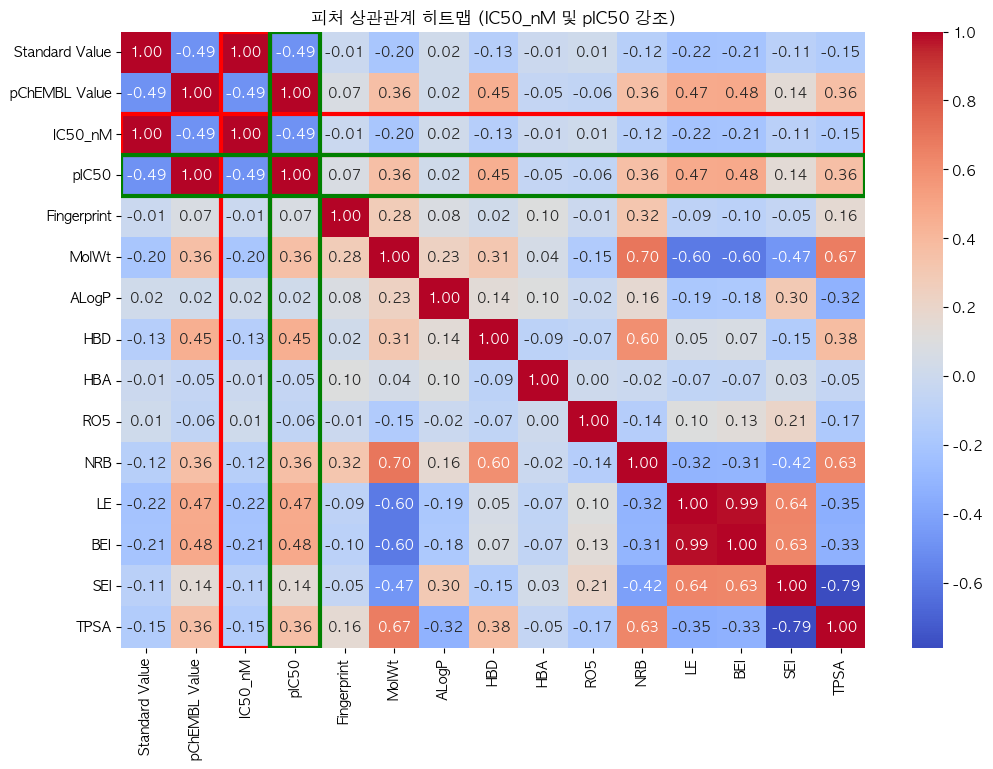

In [54]:
# Smiles 컬럼 제외한 나머지 수치형 컬럼만 선택
chembl_dataset_numeric = chembl_dataset_scale.drop(columns=['Smiles'])

# 상관관계 계산
corr_matrix = chembl_dataset_numeric.corr()

# 강조할 컬럼 (IC50_nM, pIC50)
target_col_ic50 = 'IC50_nM'
target_col_pic50 = 'pIC50'

# 상관관계 히트맵 그리기
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# IC50_nM 컬럼을 빨간색 박스로 강조
col_index_ic50 = corr_matrix.columns.get_loc(target_col_ic50)  # IC50_nM 컬럼의 위치
plt.gca().add_patch(plt.Rectangle((col_index_ic50, 0), 1, len(corr_matrix), fill=False, edgecolor='red', lw=3))  # 세로 강조
plt.gca().add_patch(plt.Rectangle((0, col_index_ic50), len(corr_matrix), 1, fill=False, edgecolor='red', lw=3))  # 가로 강조

# pIC50 컬럼을 파란색 박스로 강조
col_index_pic50 = corr_matrix.columns.get_loc(target_col_pic50)  # pIC50 컬럼의 위치
plt.gca().add_patch(plt.Rectangle((col_index_pic50, 0), 1, len(corr_matrix), fill=False, edgecolor='green', lw=3))  # 세로 강조
plt.gca().add_patch(plt.Rectangle((0, col_index_pic50), len(corr_matrix), 1, fill=False, edgecolor='green', lw=3))  # 가로 강조

plt.title('피처 상관관계 히트맵 (IC50_nM 및 pIC50 강조)')
plt.show()

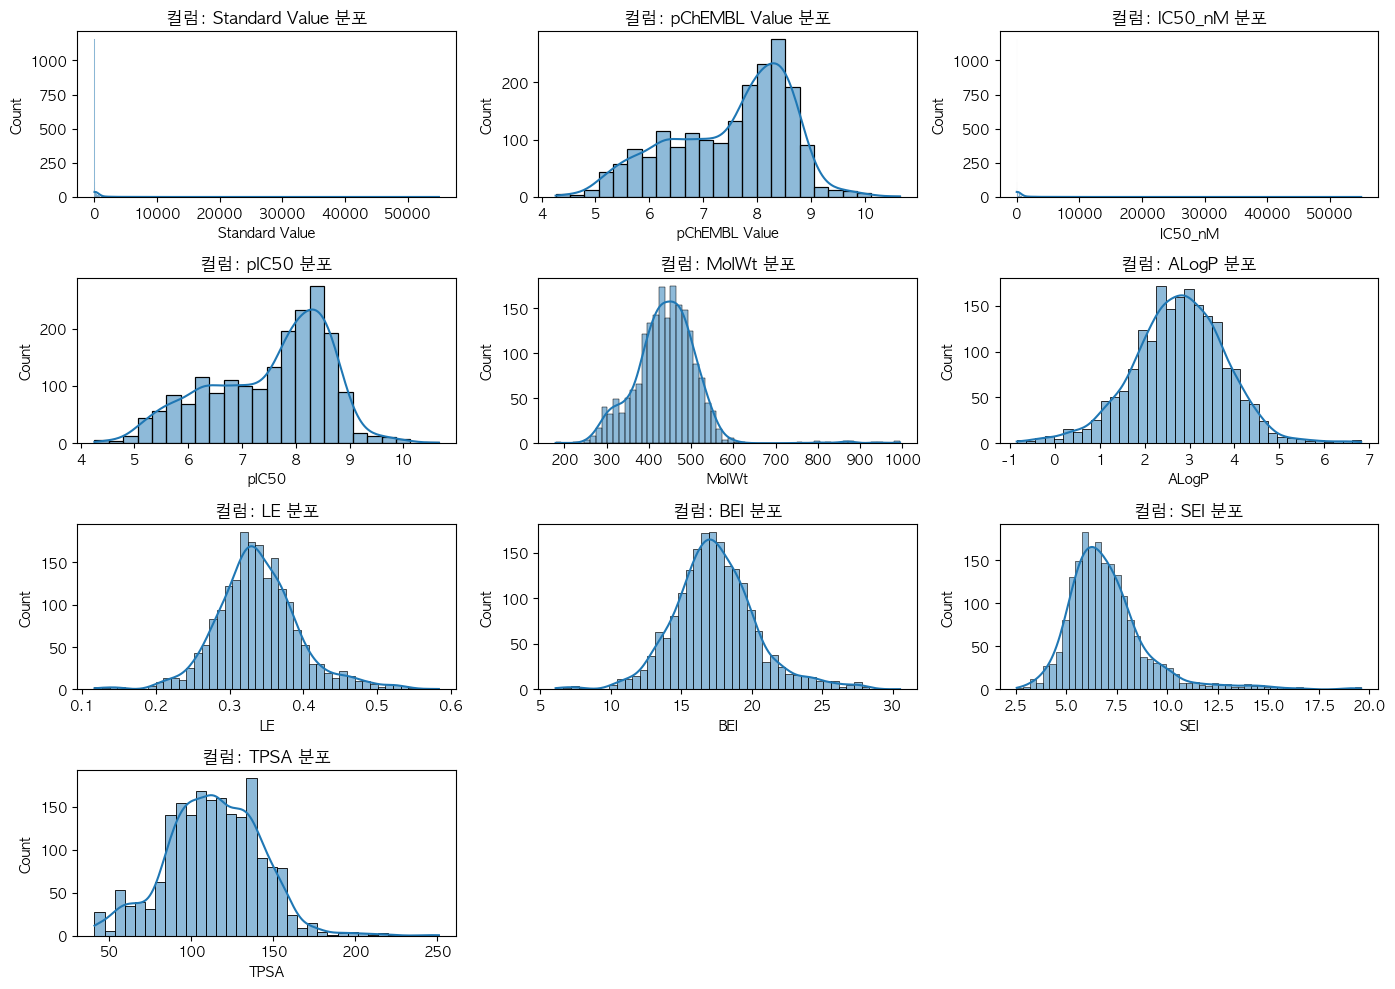

In [56]:
# 각 연속형 피처에 대한 분포 시각화 (히스토그램)
plt.figure(figsize=(14, 10))
for i, col in enumerate(columns_to_scale):
    plt.subplot(4, 3, i + 1)
    sns.histplot(chembl_dataset[col], kde=True)
    plt.title(f'컬럼: {col} 분포')
plt.tight_layout()
plt.show()

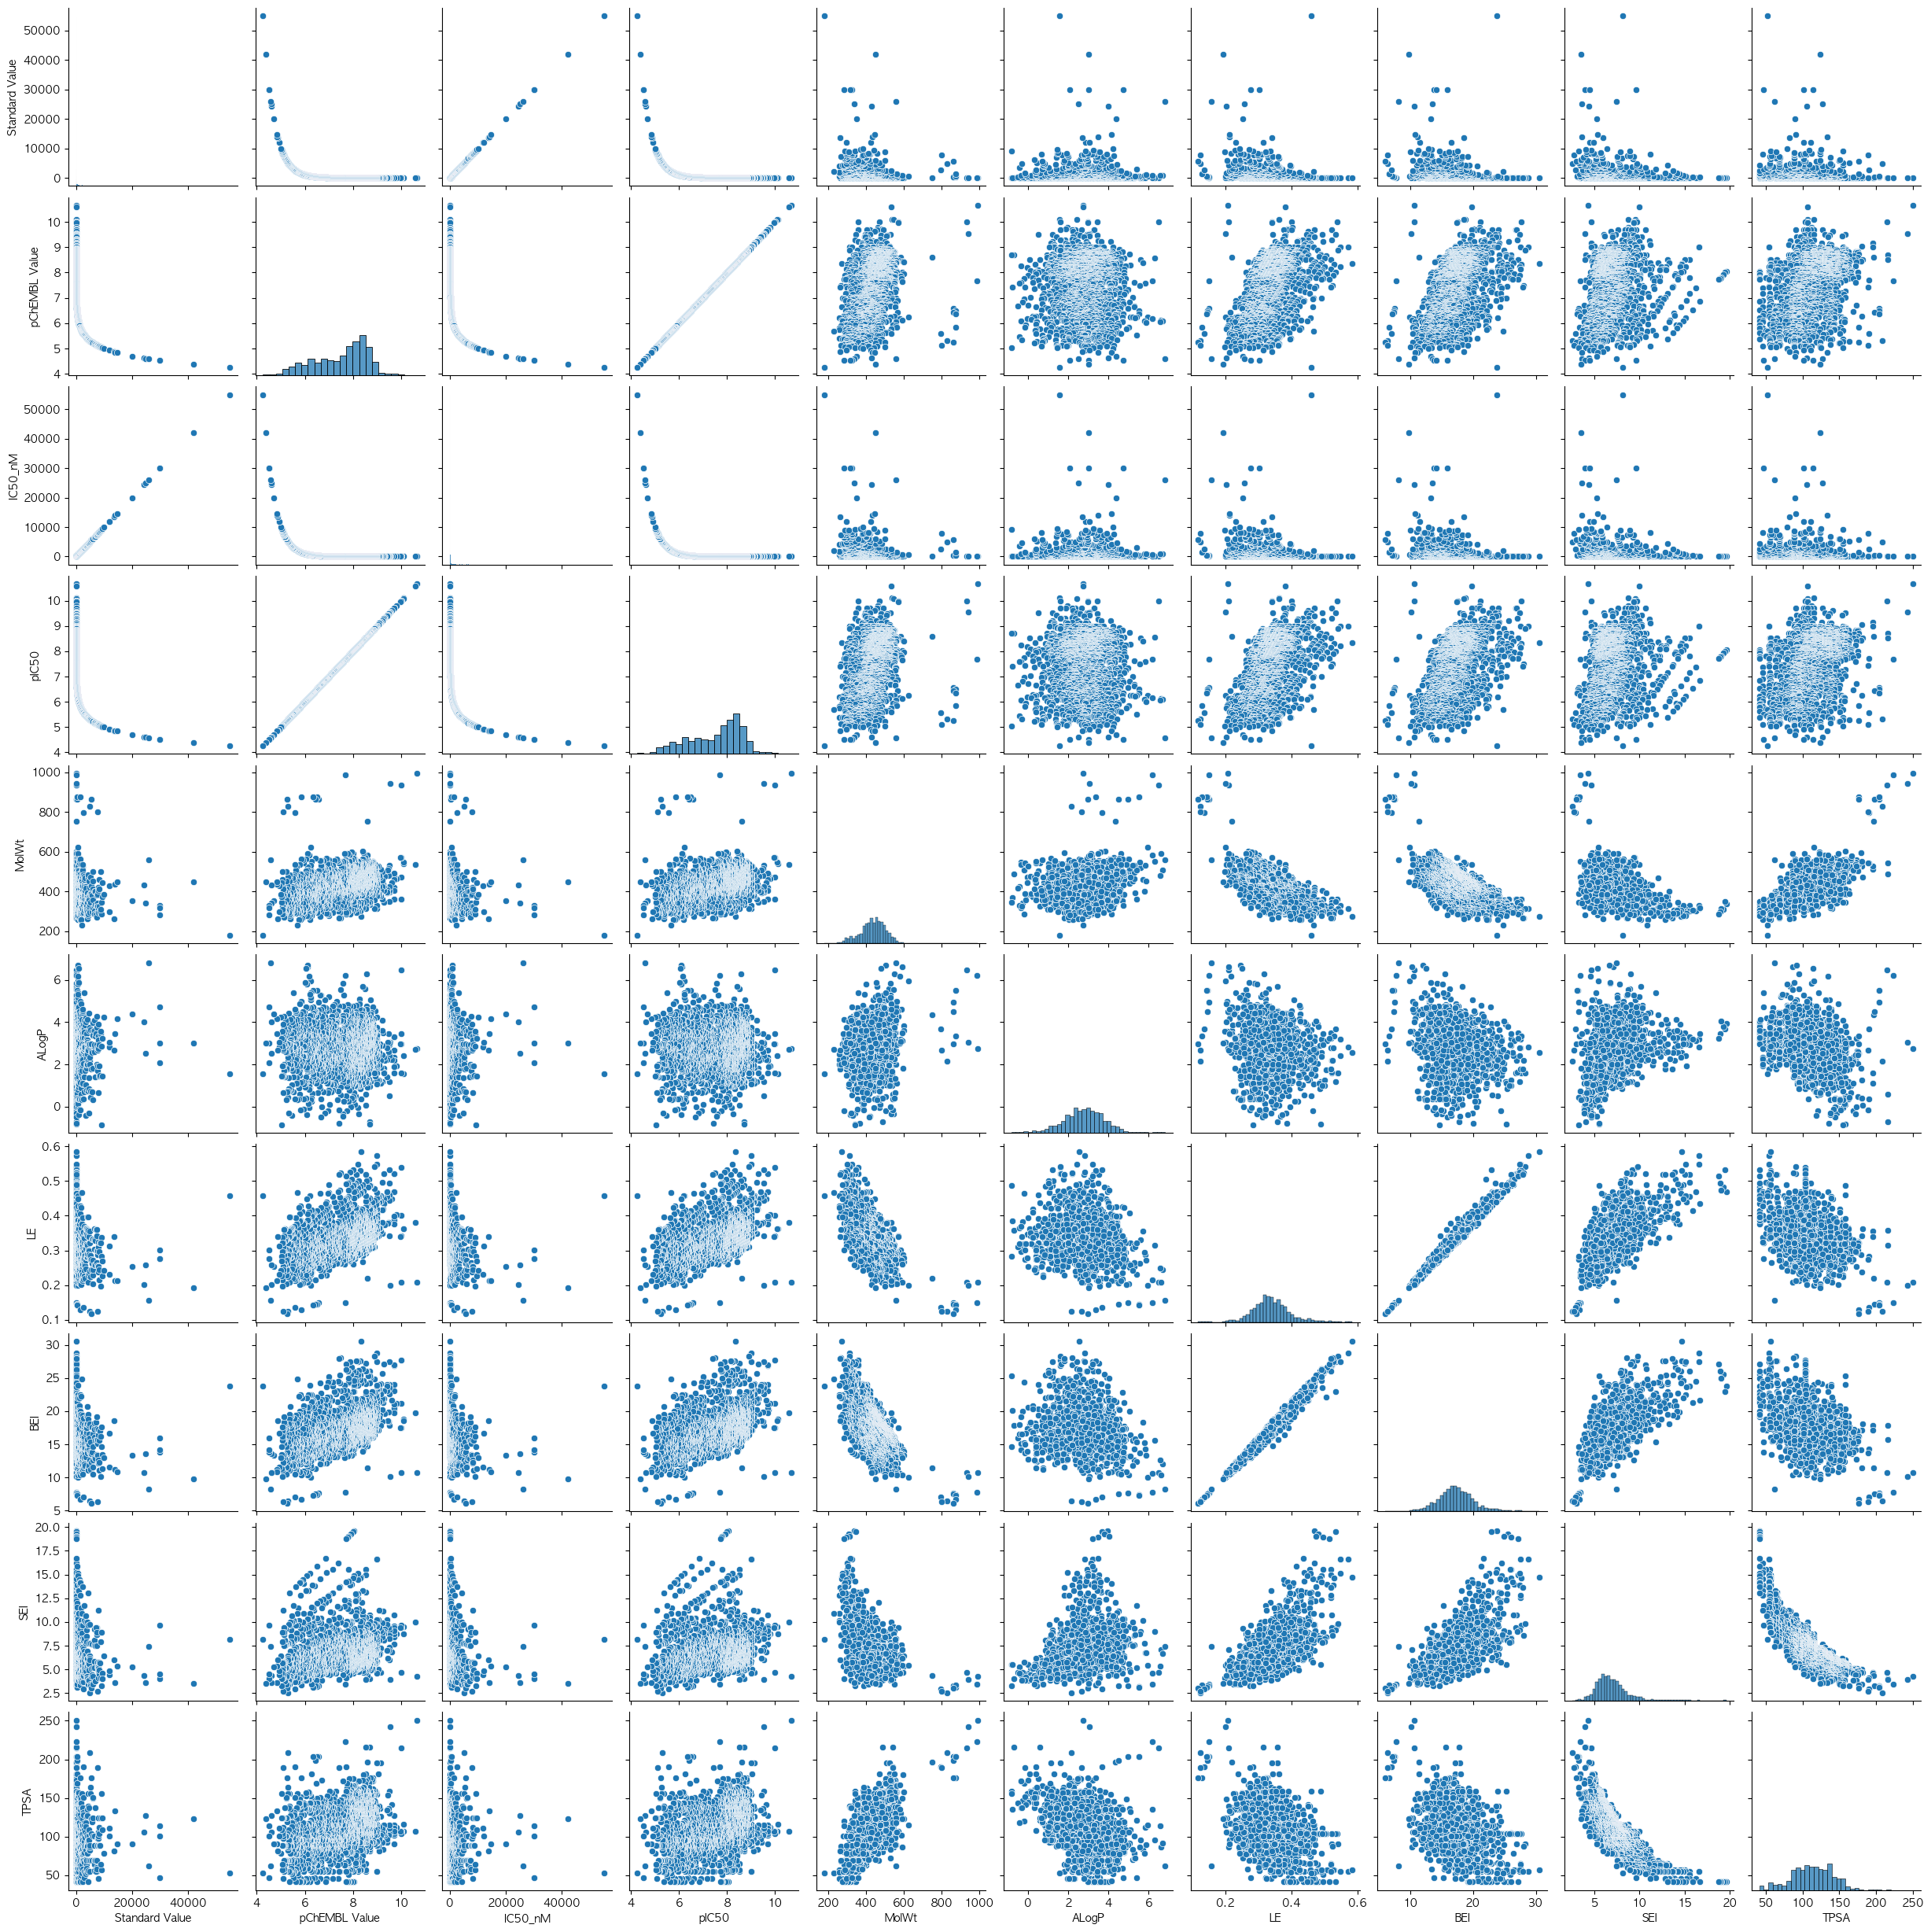

In [57]:
# 주요 피처들의 관계를 시각화하는 쌍플롯
sns.pairplot(chembl_dataset[columns_to_scale])
plt.show()

## 데이터 전처리

In [58]:
# 결측치 확인 및 처리, 0이면 결측치 없음.
print(chembl_dataset_scale.isnull().sum())

Smiles            0
Standard Value    0
pChEMBL Value     0
IC50_nM           0
pIC50             0
Fingerprint       0
MolWt             0
ALogP             0
HBD               0
HBA               0
RO5               0
NRB               0
LE                0
BEI               0
SEI               0
TPSA              0
dtype: int64


In [59]:
# 다시보니, Standard Value 와 IC50_nM이 동일한 의미를 가지며, 실제 값도 동일함
# pChEMBL Value 도 pIC50과 동일함 따라서 두 컬럼 제거
chembl_preprocessing_dataset = chembl_dataset_scale.drop(columns=['Standard Value', 'pChEMBL Value'])

# 결과 확인
display(chembl_preprocessing_dataset)

,Smiles,IC50_nM,pIC50,Fingerprint,MolWt,ALogP,HBD,HBA,RO5,NRB,LE,BEI,SEI,TPSA
0,CN[C@@H](C)C(=O)N[C@H](C(=O)N1C[C@@H](NC(=O)CC...,-0.245893,2.836042,1,7.380595,-0.024868,1,1,0,23,-2.294301,-2.220994,-1.362246,4.821051
1,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,-0.245892,2.772846,0,1.272098,-0.046698,1,0,0,7,0.725667,0.788066,1.436393,-0.251630
2,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,-0.245872,2.339506,0,1.298424,-1.156186,1,0,0,7,0.426241,0.467323,0.842971,0.072255
3,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,-0.245871,2.321451,0,1.404650,-0.323084,1,0,0,8,0.415955,0.363659,1.205964,-0.251630
4,COc1cc2c(OC[C@@H]3CCC(=O)N3)ncc(C#CCCCCCCCCCCC...,-0.245864,2.240199,1,6.595097,3.581060,1,0,0,21,-2.262557,-2.230575,-1.167115,3.568321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,O=C(Nc1nc2cc[nH]cc-2n1)c1cccc([N+](=O)[O-])c1,11.120876,-2.707098,0,-2.082456,-0.672654,0,0,0,3,-0.645818,-0.478752,-1.498293,0.011549
1948,CCCCn1c(NC(=O)c2cccc(Cl)c2)nc2ccccc21,11.120876,-2.707098,0,-1.496629,1.897046,0,0,0,5,-1.104196,-1.192358,1.275686,-2.335654
1949,O=C(Nc1nc2cc(F)c(F)cc2[nH]1)c1cccc([N+](=O)[O-...,11.120876,-2.707098,0,-1.617103,0.223245,0,0,0,3,-1.104196,-1.061749,-1.249765,-0.440768
1950,OC[C@H]1C[C@@H](Nc2nc(Nc3ccccc3)ncc2-c2nc3cccc...,15.667587,-2.833489,0,0.126621,0.232670,0,0,0,6,-2.569609,-2.541984,-1.705377,0.348768


In [63]:
# 데이터 저장 (전처리 완료)
chembl_dataset_scale.to_csv('../preprocessed_data/test1.csv', index=False)

In [64]:
# 필요한 컬럼 추출 -> train
train = chembl_dataset_scale[[
    'Smiles', 'pIC50', 'Fingerprint', 'MolWt', 'ALogP', 
    'HBD', 'HBA', 'RO5', 'NRB', 'LE', 'BEI', 'SEI', 'TPSA',
]]

# 입력 데이터 (X)와 타겟 데이터 (y) 준비
train_x = train.drop(columns=['pIC50', 'Smiles']).values  # pIC50와 Smiles를 제외한 나머지 피처들로 학습 데이터 생성
train_y = train['pIC50'].values  # pIC50 값을 numpy 배열로 변환

# 학습 및 검증 데이터 분리 (70% 학습, 30% 검증)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.3, random_state=42)

# 결과 확인
print(f"train_x shape: {train_x.shape}, train_y shape: {train_y.shape}")
print(f"val_x shape: {val_x.shape}, val_y shape: {val_y.shape}")

train_x shape: (1366, 11), train_y shape: (1366,)
val_x shape: (586, 11), val_y shape: (586,)


# Modeling & Training

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# 랜덤 포레스트 모델 학습
model = RandomForestRegressor(random_state=CFG['SEED'])

# 모델 학습
model.fit(train_x, train_y)

In [ ]:
def pIC50_to_IC50(pic50_values):
    """Convert pIC50 values to IC50 (nM)."""
    return 10 ** (9 - pic50_values)

# Validation 데이터로부터의 학습 모델 평가
val_y_pred = model.predict(val_x)

# pIC50 값을 IC50으로 변환한 후 MSE 및 RMSE 계산
mse = mean_squared_error(pIC50_to_IC50(val_y), pIC50_to_IC50(val_y_pred))
rmse = np.sqrt(mse)

print(f'검증 데이터 RMSE: {rmse}')

In [ ]:
# 5-폴드 교차 검증
cv_scores = cross_val_score(model, train_x, train_y, cv=5, scoring='neg_mean_squared_error')

# 교차 검증 RMSE로 변환
cv_rmse = (-cv_scores)**0.5
print(f'교차 검증 RMSE: {cv_rmse.mean()}')

In [ ]:
from sklearn.model_selection import GridSearchCV

# 추가적으로 하이퍼파라미터 튜닝을 통해 최적의 모델 찾기
# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],  # 결정 트리 개수
    'max_depth': [None, 10, 20, 30],  # 최대 깊이
    'min_samples_split': [2, 5, 10],  # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4],  # 리프 노드에 있어야 할 최소 샘플 수
    'bootstrap': [True, False]  # 부트스트랩 샘플링 사용 여부
}

# GridSearchCV를 사용한 하이퍼파라미터 튜닝
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
# 그리드 서치 모델 학습
grid_search.fit(train_x, train_y)

# 최적의 모델과 하이퍼파라미터 출력
print(f"최적의 하이퍼파라미터: {grid_search.best_params_}")

# 최적의 모델로 검증 데이터 예측
best_model = grid_search.best_estimator_
val_y_pred_best = best_model.predict(val_x)

# 최적의 모델로 검증 데이터에 대한 RMSE 계산
best_mse = mean_squared_error(pIC50_to_IC50(val_y), pIC50_to_IC50(val_y_pred_best))
best_rmse = np.sqrt(best_mse)

print(f'최적 모델 검증 데이터 RMSE: {best_rmse}')

# Inference

In [ ]:
test = pd.read_csv('./test.csv')
test['Fingerprint'] = test['Smiles'].apply(smiles_to_fingerprint)

test_x = np.stack(test['Fingerprint'].values)

test_y_pred = model.predict(test_x)

# Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['IC50_nM'] = pIC50_to_IC50(test_y_pred)
submit.head()

In [ ]:
submit.to_csv('./baseline_submit.csv', index=False)